# Install and Import

In [29]:
! pip install geopandas
! pip install folium

In [30]:
import numpy as np
import pandas as pd
import geopandas as gpd
from geopandas.tools import geocode
import math
from collections import namedtuple

import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
import matplotlib.ticker as mtick
from random import sample 
import datetime
from pandas.plotting import register_matplotlib_converters

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster, TimestampedGeoJson

import datetime
import os

In [31]:
register_matplotlib_converters()

# Section -2

## Get data

In [32]:
global_confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
global_death = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
global_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [33]:
global_confirmed.head() 

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,9/10/20,9/11/20,9/12/20,9/13/20,9/14/20,9/15/20,9/16/20,9/17/20,9/18/20,9/19/20,9/20/20,9/21/20,9/22/20,9/23/20,9/24/20,9/25/20,9/26/20,9/27/20,9/28/20,9/29/20,9/30/20,10/1/20,10/2/20,10/3/20,10/4/20,10/5/20,10/6/20,10/7/20,10/8/20,10/9/20,10/10/20,10/11/20,10/12/20,10/13/20,10/14/20,10/15/20,10/16/20,10/17/20,10/18/20,10/19/20
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,38572,38606,38641,38716,38772,38815,38855,38872,38883,38919,39044,39074,39096,39145,39170,39186,39192,39227,39233,39254,39268,39285,39290,39297,39341,39422,39486,39548,39616,39693,39703,39799,39870,39928,39994,40026,40073,40141,40200,40287
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,10860,11021,11185,11353,11520,11672,11816,11948,12073,12226,12385,12535,12666,12787,12921,13045,13153,13259,13391,13518,13649,13806,13965,14117,14266,14410,14568,14730,14899,15066,15231,15399,15570,15752,15955,16212,16501,16774,17055,17350
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,...,47488,47752,48007,48254,48496,48734,48966,49194,49413,49623,49826,50023,50214,50400,50579,50754,50914,51067,51213,51368,51530,51690,51847,51995,52136,52270,52399,52520,52658,52804,52940,53072,53325,53399,53584,53777,53998,54203,54402,54616
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1301,1344,1344,1344,1438,1438,1483,1483,1564,1564,1564,1681,1681,1753,1753,1836,1836,1836,1966,1966,2050,2050,2110,2110,2110,2370,2370,2568,2568,2696,2696,2696,2995,2995,3190,3190,3377,3377,3377,3623
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,3217,3279,3335,3388,3439,3569,3675,3789,3848,3901,3991,4117,4236,4363,4475,4590,4672,4718,4797,4905,4972,5114,5211,5370,5402,5530,5725,5725,5958,6031,6246,6366,6488,6680,6846,7096,7222,7462,7622,7829


In [34]:
print(global_confirmed.shape, global_death.shape, global_recovered.shape)

(267, 276) (267, 276) (254, 276)


In [35]:
global_confirmed['Country/Region'].value_counts()

China             33
Canada            14
United Kingdom    11
France            11
Australia          8
                  ..
US                 1
Latvia             1
Afghanistan        1
Ethiopia           1
Eritrea            1
Name: Country/Region, Length: 189, dtype: int64

In [36]:
date = '10/15/20'

In [37]:
global_confirmed_now = global_confirmed[['Province/State', 'Country/Region', 'Lat', 'Long', date]]
global_death_now = global_death[['Province/State', 'Country/Region', 'Lat', 'Long', date]]
global_recovered_now = global_recovered[['Province/State', 'Country/Region', 'Lat', 'Long', date]]

In [38]:
global_confirmed_now.head()

,Province/State,Country/Region,Lat,Long,10/15/20
0,NaN,Afghanistan,33.93911,67.709953,40026
1,NaN,Albania,41.15330,20.168300,16212
2,NaN,Algeria,28.03390,1.659600,53777
3,NaN,Andorra,42.50630,1.521800,3190
4,NaN,Angola,-11.20270,17.873900,7096


In [39]:
global_confirmed_now.rename(columns={date:'Confirmed'}, inplace=True)
global_death_now.rename(columns={date:'Death'}, inplace=True)
global_recovered_now.rename(columns={date:'Recovered'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [40]:
global_now = pd.merge(global_confirmed_now,global_death_now,on=['Province/State', 'Country/Region', 'Lat', 'Long'])
global_now = pd.merge(global_now,global_recovered_now,on=['Province/State', 'Country/Region', 'Lat', 'Long'])

In [41]:
global_now

,Province/State,Country/Region,Lat,Long,Confirmed,Death,Recovered
0,NaN,Afghanistan,33.939110,67.709953,40026,1481,33447
1,NaN,Albania,41.153300,20.168300,16212,439,9864
2,NaN,Algeria,28.033900,1.659600,53777,1827,37603
3,NaN,Andorra,42.506300,1.521800,3190,59,2011
4,NaN,Angola,-11.202700,17.873900,7096,228,2928
...,...,...,...,...,...,...,...
213,NaN,Venezuela,6.423800,-66.589700,85469,720,77689
214,NaN,West Bank and Gaza,31.952200,35.233200,46100,401,39585
215,NaN,Western Sahara,24.215500,-12.885800,10,1,8
216,NaN,Zambia,-13.133897,27.849332,15659,346,14899


In [42]:
us_confirmed_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
us_confirmed = us_confirmed_raw.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key', 'Lat', 'Long_'])
us_confirmed.rename(columns={'Province_State':'Province/State'}, inplace=True)
us_confirmed = us_confirmed.groupby(by='Province/State').sum().reset_index()
us_confirmed['Country/Region'] = 'US'

In [43]:
us_death_raw = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv")
us_death = us_death_raw.drop(columns=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Combined_Key', 'Lat', 'Long_'])
us_death.rename(columns={'Province_State':'Province/State'}, inplace=True)
us_death = us_death.groupby(by='Province/State').sum().reset_index()
us_death['Country/Region'] = 'US'

In [44]:
us_lat_long = pd.read_csv(
    'https://raw.githubusercontent.com/RedShuuu/Mix/master/data/US_states_lat_long.csv').drop(
        'State', axis=1).rename(
            columns={'City': 'Province/State', 'Latitude': 'Lat', 'Longitude': 'Long'})
us_lat_long.head()

,Lat,Long,Province/State
0,32.601011,-86.680736,Alabama
1,61.302501,-158.775020,Alaska
2,34.168219,-111.930907,Arizona
3,34.751928,-92.131378,Arkansas
4,37.271875,-119.270415,California


In [45]:
us_confirmed = pd.merge(us_confirmed, us_lat_long, on='Province/State')
us_death = pd.merge(us_death, us_lat_long, on='Province/State')

In [46]:
global_now_no_us = global_now.drop(index=global_now[global_now['Country/Region'] == 'US'].index)
global_now_no_us.reset_index(inplace=True)
global_now_no_us.drop(columns='index', inplace=True)

In [47]:
us_confirmed_data_now = us_confirmed[['Province/State', 'Country/Region', 'Lat', 'Long', date]]
us_confirmed_data_now.rename(columns={date:'Confirmed'}, inplace=True)
us_death_data_now = us_death[['Province/State', 'Country/Region', 'Lat', 'Long', date]]
us_death_data_now.rename(columns={date:'Death'}, inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
us_now = pd.merge(us_confirmed_data_now, us_death_data_now, on=['Province/State', 'Country/Region', 'Lat', 'Long'])

## Plot

In [49]:
us_confirmed_series = global_confirmed[global_confirmed['Country/Region']=='US'].reset_index().drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long', 'index'])
us_death_series = global_death[global_death['Country/Region']=='US'].reset_index().drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long', 'index'])
us_recovered_series = global_recovered[global_recovered['Country/Region']=='US'].reset_index().drop(columns=['Province/State', 'Country/Region', 'Lat', 'Long', 'index'])

In [50]:
us_confirmed_series = us_confirmed_series.T.rename(columns={0: 'Confirmed'})
us_confirmed_series.index = pd.to_datetime(us_confirmed_series.index)
us_death_series = us_death_series.T.rename(columns={0: 'Death'})
us_death_series.index = pd.to_datetime(us_death_series.index)
us_recovered_series = us_recovered_series.T.rename(columns={0: 'Recovered'})
us_recovered_series.index = pd.to_datetime(us_recovered_series.index)

In [51]:
us_confirmed_series

,Confirmed
2020-01-22,1
2020-01-23,1
2020-01-24,2
2020-01-25,2
2020-01-26,5
...,...
2020-10-15,7979709
2020-10-16,8048865
2020-10-17,8106384
2020-10-18,8154594


Populating the interactive namespace from numpy and matplotlib


Text(0.5, 1.0, 'United States Covid-19 Confirmed\n(data: Johns Hopkins Univrsity)')

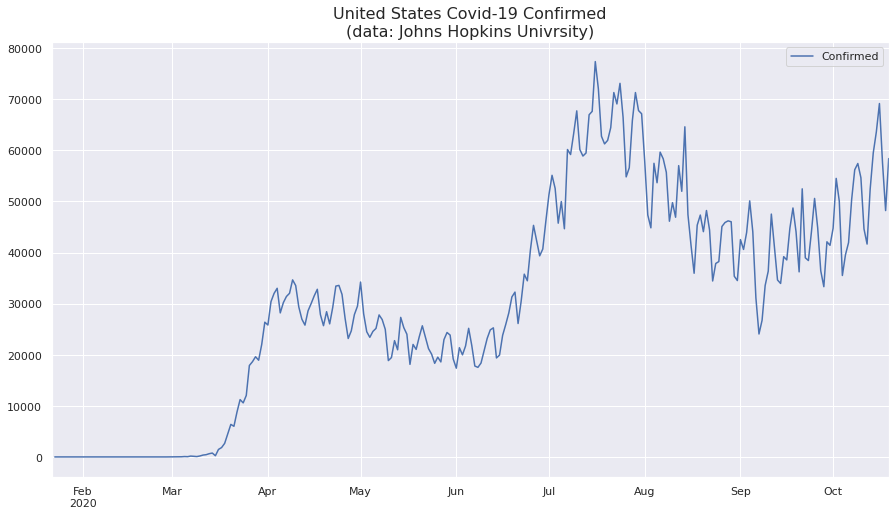

In [69]:
%matplotlib inline 
%pylab inline

pylab.rcParams['figure.figsize'] = (15, 8)   # set image size


sns.set(color_codes=True)
us_confirmed_series.diff().plot()
plt.title('United States Covid-19 Confirmed\n(data: Johns Hopkins Univrsity)', fontsize=16)

In [53]:
plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

## Create map

In [54]:
map_now = folium.Map(location=[30, 0], 
                 tiles = "CartoDB dark_matter",
                 detect_retina = True,
                 zoom_start=2,
                 no_touch=True)

In [55]:
world_countries_geo = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"

folium.Choropleth(
    geo_data=world_countries_geo,
    name='choropleth',
#     data=filtered_data_last,
#     columns=['Province/State', 'Confirmed'],
    key_on='feature.properties.name',
    fill_color='green',
    fill_opacity=0.18,
    line_opacity=0.7
).add_to(map_now)

In [56]:
for i in range(len(global_now_no_us)):
  lat = global_now_no_us.loc[i, 'Lat']
  lon = global_now_no_us.loc[i, 'Long']
  country = global_now_no_us.loc[i, 'Country/Region']
  province = global_now_no_us.loc[i, 'Province/State']
  if str(province) == 'nan':
    province=''
  recovered = global_now_no_us.loc[i, 'Recovered']
  death = global_now_no_us.loc[i, 'Death']
  confirmed = global_now_no_us.loc[i, 'Confirmed']

  if confirmed == 0 :
    _radius_rec = 0
  else:
    _radius_rec = math.pow(confirmed,1/3)

  _popup_rec = str(country) + ' ' + str(province) + '(Confirmed='+str(confirmed) + ' Deaths=' + str(death) + ' Recovered=' + str(recovered) + ')'

  _color_rec = '#81D8D0'

  folium.CircleMarker(location = [lat,lon], 
                        radius = _radius_rec, 
                        popup = _popup_rec, 
                        color = _color_rec, 
                        fill_opacity = 0.1,
                      weight = 2, 
                      fill = True, 
                      fillColor = _color_rec).add_to(map_now) 

In [57]:
for i in range(len(us_now)):
  lat = us_now.loc[i, 'Lat']
  lon = us_now.loc[i, 'Long']
  country = us_now.loc[i, 'Country/Region']
  province = us_now.loc[i, 'Province/State']
  death = us_now.loc[i, 'Death']
  confirmed = us_now.loc[i, 'Confirmed']

  if confirmed == 0 :
    _radius_rec = 0
  else:
    _radius_rec = math.pow(confirmed,1/3)

  _popup_rec = str(country) + ' ' + str(province) + '(Confirmed='+str(confirmed) + ' Deaths=' + str(death) + ')'

  _color_rec = '#81D8D0'

  folium.CircleMarker(location = [lat,lon], 
                        radius = _radius_rec, 
                        popup = _popup_rec, 
                        color = _color_rec, 
                        fill_opacity = 0.1,
                      weight = 2, 
                      fill = True, 
                      fillColor = _color_rec).add_to(map_now) 

In [58]:
map_now

In [59]:
# map_now.save('confirmed_1013.html')

# Section -1

In [75]:
date = '10-13-2020'
daily_report_data_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/' + date + '.csv'

In [76]:
daily_report_raw_data = pd.read_csv(daily_report_data_url)

In [77]:
daily_report_raw_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
0,NaN,NaN,NaN,Afghanistan,2020-10-14 04:24:05,33.93911,67.709953,39928,1480,33308,5140.0,Afghanistan,102.567947,3.706672
1,NaN,NaN,NaN,Albania,2020-10-14 04:24:05,41.15330,20.168300,15752,429,9675,5648.0,Albania,547.362569,2.723464
2,NaN,NaN,NaN,Algeria,2020-10-14 04:24:05,28.03390,1.659600,53399,1818,37492,14089.0,Algeria,121.773614,3.404558
3,NaN,NaN,NaN,Andorra,2020-10-14 04:24:05,42.50630,1.521800,2995,57,1928,1010.0,Andorra,3876.269980,1.903172
4,NaN,NaN,NaN,Angola,2020-10-14 04:24:05,-11.20270,17.873900,6680,222,2761,3697.0,Angola,20.324790,3.323353


In [78]:
daily_report_raw_data[daily_report_raw_data['Province_State'] == 'New Jersey'].head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio
2445,34001.0,Atlantic,New Jersey,US,2020-10-14 04:24:05,39.475387,-74.658485,4517,261,0,4256.0,"Atlantic, New Jersey, US",1713.126256,5.778171
2446,34003.0,Bergen,New Jersey,US,2020-10-14 04:24:05,40.960109,-74.071643,23323,2052,0,21271.0,"Bergen, New Jersey, US",2501.925548,8.798182
2447,34005.0,Burlington,New Jersey,US,2020-10-14 04:24:05,39.876811,-74.669278,7598,504,0,7094.0,"Burlington, New Jersey, US",1706.077705,6.633325
2448,34007.0,Camden,New Jersey,US,2020-10-14 04:24:05,39.803438,-74.963888,10553,615,0,9938.0,"Camden, New Jersey, US",2083.633614,5.827727
2449,34009.0,Cape May,New Jersey,US,2020-10-14 04:24:05,39.150088,-74.801702,1060,99,0,961.0,"Cape May, New Jersey, US",1151.685698,9.339623


In [71]:
import time
from datetime import datetime, timedelta, timezone

In [83]:
today_date = datetime.today()
today_date

datetime.datetime(2020, 10, 20, 19, 19, 4, 775255)

In [84]:
today_date - timedelta(days=1)

datetime.datetime(2020, 10, 19, 19, 19, 4, 775255)

In [98]:
d = today_date
for i in range(365):
  d = d - timedelta(days=1)
  s = str(d)[5:10] + '-' + str(d)[0:4]
  if s == '03-21-2020': break
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/' + s + '.csv'
  try:
    df = pd.read_csv(url)
  except:
    break
  nj_df = df[df['Province_State'] == 'New Jersey']
  nj_df['Date'] = s
  if i == 0:
    nj_data = nj_df
  else:
    nj_data = pd.concat([nj_data, nj_df], axis=0, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [103]:
d = datetime(2020, 3, 21)
for i in range(365):
  s = str(d)[5:10] + '-' + str(d)[0:4]
  url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/' + s + '.csv'
  try:
    df = pd.read_csv(url)
  except:
    break
  nj_df = df[df['Province/State'] == 'New Jersey']
  nj_df['Date'] = s
  if i == 0:
    nj_data2 = nj_df
  else:
    nj_data2 = pd.concat([nj_data2, nj_df], axis=0, ignore_index=True)
  d = d - timedelta(days=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [99]:
nj_data.shape

(4664, 15)

In [100]:
nj_data.head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Incidence_Rate,Case-Fatality_Ratio,Date
0,34001.0,Atlantic,New Jersey,US,2020-10-20 04:24:22,39.475387,-74.658485,4753,264,0,4489.0,"Atlantic, New Jersey, US",1802.632078,5.554387,10-19-2020
1,34003.0,Bergen,New Jersey,US,2020-10-20 04:24:22,40.960109,-74.071643,23845,2051,0,21794.0,"Bergen, New Jersey, US",2557.921995,8.601384,10-19-2020
2,34005.0,Burlington,New Jersey,US,2020-10-20 04:24:22,39.876811,-74.669278,7885,507,0,7378.0,"Burlington, New Jersey, US",1770.521546,6.429930,10-19-2020
3,34007.0,Camden,New Jersey,US,2020-10-20 04:24:22,39.803438,-74.963888,10908,618,0,10290.0,"Camden, New Jersey, US",2153.726472,5.665567,10-19-2020
4,34009.0,Cape May,New Jersey,US,2020-10-20 04:24:22,39.150088,-74.801702,1077,99,0,978.0,"Cape May, New Jersey, US",1170.156129,9.192201,10-19-2020


In [106]:
nj_data.drop(columns=['FIPS', 'Country_Region', 'Last_Update', 'Incidence_Rate', 'Case-Fatality_Ratio'], inplace=True)
nj_data.head()

,Admin2,Province_State,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key,Date
0,Atlantic,New Jersey,39.475387,-74.658485,4753,264,0,4489.0,"Atlantic, New Jersey, US",10-19-2020
1,Bergen,New Jersey,40.960109,-74.071643,23845,2051,0,21794.0,"Bergen, New Jersey, US",10-19-2020
2,Burlington,New Jersey,39.876811,-74.669278,7885,507,0,7378.0,"Burlington, New Jersey, US",10-19-2020
3,Camden,New Jersey,39.803438,-74.963888,10908,618,0,10290.0,"Camden, New Jersey, US",10-19-2020
4,Cape May,New Jersey,39.150088,-74.801702,1077,99,0,978.0,"Cape May, New Jersey, US",10-19-2020


In [110]:
nj_data.rename(columns={'Long_': 'Long'}, inplace=True)

In [111]:
nj_data.head()

,Admin2,Province_State,Lat,Long,Confirmed,Deaths,Recovered,Active,Combined_Key,Date
0,Atlantic,New Jersey,39.475387,-74.658485,4753,264,0,4489.0,"Atlantic, New Jersey, US",10-19-2020
1,Bergen,New Jersey,40.960109,-74.071643,23845,2051,0,21794.0,"Bergen, New Jersey, US",10-19-2020
2,Burlington,New Jersey,39.876811,-74.669278,7885,507,0,7378.0,"Burlington, New Jersey, US",10-19-2020
3,Camden,New Jersey,39.803438,-74.963888,10908,618,0,10290.0,"Camden, New Jersey, US",10-19-2020
4,Cape May,New Jersey,39.150088,-74.801702,1077,99,0,978.0,"Cape May, New Jersey, US",10-19-2020


In [105]:
nj_data2.shape

(12, 9)

In [104]:
nj_data2.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude,Date
0,New Jersey,US,2020-03-21T19:43:03,1327.0,16.0,0.0,40.2989,-74.521,03-21-2020
1,New Jersey,US,2020-03-20T21:13:32,890.0,11.0,0.0,40.2989,-74.521,03-20-2020
2,New Jersey,US,2020-03-19T23:43:04,742.0,9.0,0.0,40.2989,-74.521,03-19-2020
3,New Jersey,US,2020-03-18T14:13:56,267.0,3.0,0.0,40.2989,-74.521,03-18-2020
4,New Jersey,US,2020-03-17T20:13:22,267.0,3.0,1.0,40.2989,-74.521,03-17-2020


In [119]:
nj_data2['Admin2'] = np.nan
nj_data2.drop(columns=['Country/Region', 'Last Update'], inplace=True)
nj_data2.rename(columns={'Province/State': 'Province_State', 'Latitude': 'lat', 'Longitude': 'Long'}, inplace=True)

In [114]:
nj_data2['Combined_Key'] = 'New Jersey, US'

In [120]:
nj_data2.head()

,Province_State,Confirmed,Deaths,Recovered,lat,Long,Date,Admin2,Combined_Key
0,New Jersey,1327.0,16.0,0.0,40.2989,-74.521,03-21-2020,NaN,"New Jersey, US"
1,New Jersey,890.0,11.0,0.0,40.2989,-74.521,03-20-2020,NaN,"New Jersey, US"
2,New Jersey,742.0,9.0,0.0,40.2989,-74.521,03-19-2020,NaN,"New Jersey, US"
3,New Jersey,267.0,3.0,0.0,40.2989,-74.521,03-18-2020,NaN,"New Jersey, US"
4,New Jersey,267.0,3.0,1.0,40.2989,-74.521,03-17-2020,NaN,"New Jersey, US"


# Reference

[2019-nCoV疫情传播可视化和预测--交互式地图分析
](https://www.kesci.com/home/project/5e44d8d15f2816002cec62a0)

[Visualizing Bike Mobility in London using Interactive Maps and Animations](https://towardsdatascience.com/visualizing-bike-mobility-in-london-using-interactive-maps-for-absolute-beginners-3b9f55ccb59)

[Tracking the spread of 2019 Coronavirus](https://www.kaggle.com/gpreda/tracking-the-spread-of-2019-coronavirus)